## CITEseq data analysis
*Author: Lena Boehme, Taghon lab, 2024*

## CMA mapping along time

The entire CITE-seq data set was clustered at very high resolution to obtain several hundered annotation-independent clusters. These were then mapped to the CMA via Visium deconvolution. The CMA values per mini-cluster were then transferred back to the individual CITE-seq cells. This allows us to plot CITE-seq cells according to their spatio-temporal context.

In a reverse approach, we carried out KNN-matching based annotation of segmented cells from the IBEX imaging data using the CITE-seq data as reference. IBEX cells were then mapped to the CMA and pseudotime was inferred from the CITE-seq cells. This again allowed plotting of cells (IBEX cells in this case) in space and time. 

### Setup

In [2]:
options(repr.plot.width=12, repr.plot.height=6)

options(scipen=100) #avoid scientific notation of numbers

library(SeuratDisk)
library(Seurat)
library(matrixStats)
library(ggplot2)
library(pheatmap)
library(reshape2)
library(dplyr)
library(tidyr)
library(viridis)
library(RColorBrewer)
library(stringr)
library(pals)
library(ggrastr)

Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat

Attaching SeuratObject


Attaching package: ‘dplyr’


The following object is masked from ‘package:matrixStats’:

    count


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidyr’


The following object is masked from ‘package:reshape2’:

    smiths


Loading required package: viridisLite


Attaching package: ‘pals’


The following objects are masked from ‘package:viridis’:

    cividis, inferno, magma, plasma, turbo, viridis


The following objects are masked from ‘package:viridisLite’:

    cividis, inferno, magma, plasma, turbo, viridis




In [2]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.6 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.9.0 
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_GB.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_GB.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Brussels
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] ggrastr_1.0.2         pals_1.8              stringr_1.5.1        
 [4] RColorBrewer_1.1-3    viridis_0.6.4         viridisLite_0.4.2    
 [7] tidyr_1.3.0           dplyr_1.1.4           reshape2_1.4.4    

In [9]:
pal24 <- colorRampPalette(brewer.pal(12, "Paired"))(24)
pal36 <- colorRampPalette(brewer.pal(12, "Paired"))(36)
pal12 <- colorRampPalette(brewer.pal(12, "Paired"))(12)
pal60 <- colorRampPalette(brewer.pal(12, "Paired"))(60)
pal40 <- colorRampPalette(brewer.pal(12, "Paired"))(40)
pal8 <- brewer.paired(8)
pal10 <- brewer.paired(10)
pal10v2 <- pal10[c(1:5,7,9,6,8,10)]
load('./CITE_palettes.RData')

### Pseudotime

Pseudotime for CD4 and CD8 lineage cells was determined during annotation.

In [5]:
load('pseudotime.RData')

determine max pseudotime values for plotting

In [13]:
max_CD4spt <- seurObj_SP2$spt_CD4 %>% as.numeric %>% .[!is.na(.)] %>% max
max_CD8spt <- seurObj_SP2$spt_CD8 %>% as.numeric %>% .[!is.na(.)] %>% max
max_CD4spt
max_CD8spt

[1] 13.10086

[1] 13.58082

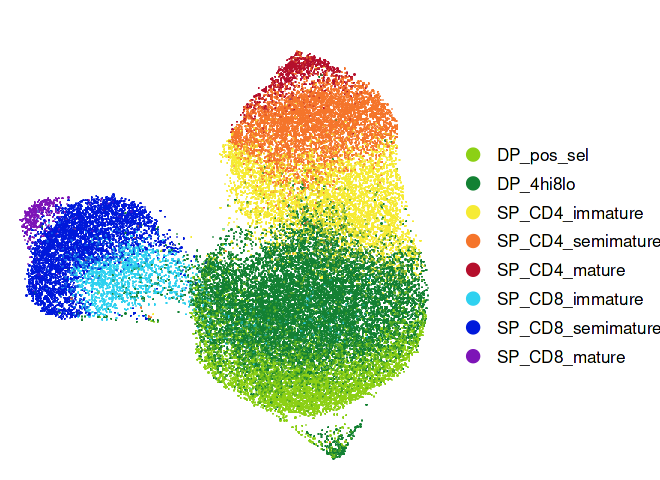

In [15]:
options(repr.plot.width=5.5, repr.plot.height=4)

p1 <- DimPlot(seurObj_SP2, reduction = 'umap_wnn_SP', group.by = 'anno_CITE_new', shuffle=T,  pt.size = 2, raster = T, raster.dpi = c(600,600), cols=pal_SPs)&
theme_void()&
labs(title = '')&
theme(legend.text=element_text(size=10))

p1

Warning message in brewer.pal(11, "PuBu"):
“n too large, allowed maximum for palette PuBu is 9
Returning the palette you asked for with that many colors
”


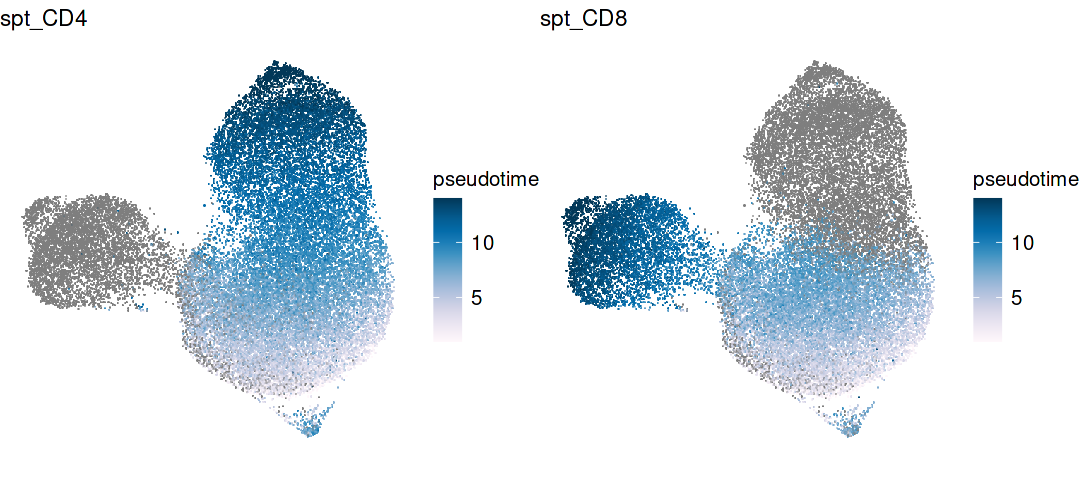

In [14]:
options(repr.plot.width=9, repr.plot.height=4)

p2 <- FeaturePlot(seurObj_SP2, features = c('spt_CD4', 'spt_CD8'), reduction = 'umap_wnn_SP', pt.size = 2, raster = T, raster.dpi = c(600,600), cols=c(colorRampPalette(brewer.pal(11, 'PuBu'))(max_CD4spt)))&
theme_void()&
labs(color = 'pseudotime')&
theme(legend.title = element_text(size=12), legend.text = element_text(size=12))
p2

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”
Warning message:
“Removed 6448 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 10817 rows containing missing values or values outside the scale range
(`geom_point()`).”


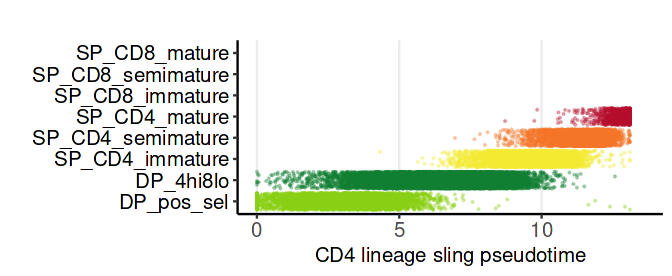

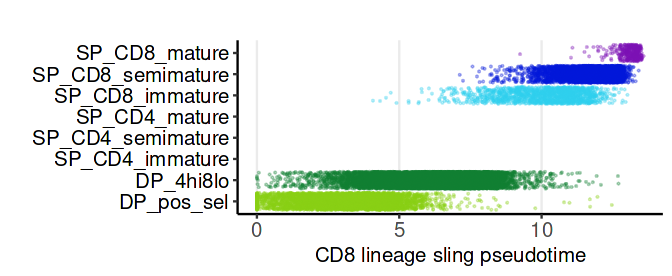

In [16]:
options(repr.plot.width=5.6, repr.plot.height=2.3)

p3 <- ggplot(ADT.df, aes(y= anno_CITE_new, x=spt_CD4, color=anno_CITE_new))+
rasterise(geom_jitter(size=0.3, alpha=0.3), dpi=300)+
theme_bw()+
scale_color_manual(values = pal_SPs)+
xlim(c(0,max_CD8spt))+
theme(panel.grid.minor.x = element_blank(), panel.grid.minor.y = element_blank(), panel.grid.major.y = element_blank())+
theme(axis.text.x = element_text(size=12), axis.text.y = element_text(size=12, color='black'), axis.title.x = element_text(size=12))+
theme(panel.border = element_blank(), axis.line = element_line(size = 0.5, linetype = "solid", colour = "black"))&
labs(title='', y='', x='CD4 lineage sling pseudotime')&NoLegend()

p4 <- ggplot(ADT.df, aes(y= anno_CITE_new, x=spt_CD8, color=anno_CITE_new))+
rasterise(geom_jitter(size=0.3, alpha=0.3), dpi=300)+
theme_bw()+
scale_color_manual(values = pal_SPs)+
xlim(c(0,max_CD8spt))+
theme(panel.grid.minor.x = element_blank(), panel.grid.minor.y = element_blank(), panel.grid.major.y = element_blank())+
theme(axis.text.x = element_text(size=12), axis.text.y = element_text(size=12, color='black'), axis.title.x = element_text(size=12))+
theme(panel.border = element_blank(), axis.line = element_line(size = 0.5, linetype = "solid", colour = "black"))&
labs(title='', y='', x='CD8 lineage sling pseudotime')&NoLegend()

p3
p4

#### Visium data

Visium-derived CMA values were project back onto CITE-seq cells.

In [6]:
cma_visium <- read.csv("")

In [7]:
head(cma_visium)

,barcode,n_genes,sample_barcode,batch,chemistry_simple,age_group,age_numeric,sampleID_TCRab,path_TCRab,path_cellbender_gex,⋯,low_ADT,spt_CD4,spt_CD8,anno_CITE,cell_type_level_4_explore,hyper_leiden,X_indices,X_scvi_batch,X_scvi_labels,mean_hyper_cma_exp
,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<int>,<dbl>
1,GEX1-GATGAAAAGTGGTAAT-0,2455,sample1-GATGAAAAGTGGTAAT,0,5GEX,paed(early),2,TCR1,lustre/scratch127/cellgen/cellgeni/tickets/tic-1740/vdj_results/TCR1,/lustre/scratch126/cellgen/team205/sharedData/ny1/22-03-07-cellbender/GEX1,⋯,0,NA,NA,B-memory,B-memory,290,0,30,290,0.3826432
2,GEX1-GCTGGGTTCATCGATG-0,2080,sample1-GCTGGGTTCATCGATG,0,5GEX,paed(early),2,TCR1,lustre/scratch127/cellgen/cellgeni/tickets/tic-1740/vdj_results/TCR1,/lustre/scratch126/cellgen/team205/sharedData/ny1/22-03-07-cellbender/GEX1,⋯,0,NA,NA,B-memory,B-memory,78,1,30,78,0.4038619
3,GEX1-TGCGCAGAGTTAAGTG-0,1684,sample1-TGCGCAGAGTTAAGTG,0,5GEX,paed(early),2,TCR1,lustre/scratch127/cellgen/cellgeni/tickets/tic-1740/vdj_results/TCR1,/lustre/scratch126/cellgen/team205/sharedData/ny1/22-03-07-cellbender/GEX1,⋯,0,NA,NA,B-memory,B-memory,157,2,30,157,0.4005413
4,GEX1-ACCAGTATCTGTACGA-0,2028,sample1-ACCAGTATCTGTACGA,0,5GEX,paed(early),2,TCR1,lustre/scratch127/cellgen/cellgeni/tickets/tic-1740/vdj_results/TCR1,/lustre/scratch126/cellgen/team205/sharedData/ny1/22-03-07-cellbender/GEX1,⋯,0,NA,NA,B-memory,B-memory,78,3,30,78,0.4038619
5,GEX1-CTCGAAACATAGTAAG-0,1594,sample1-CTCGAAACATAGTAAG,0,5GEX,paed(early),2,TCR1,lustre/scratch127/cellgen/cellgeni/tickets/tic-1740/vdj_results/TCR1,/lustre/scratch126/cellgen/team205/sharedData/ny1/22-03-07-cellbender/GEX1,⋯,0,NA,NA,B-memory,B-memory,18,4,30,18,0.4047608
6,GEX1-GATTCAGAGAGTCTGG-0,1726,sample1-GATTCAGAGAGTCTGG,0,5GEX,paed(early),2,TCR1,lustre/scratch127/cellgen/cellgeni/tickets/tic-1740/vdj_results/TCR1,/lustre/scratch126/cellgen/team205/sharedData/ny1/22-03-07-cellbender/GEX1,⋯,0,NA,NA,B-memory,B-memory,198,5,30,198,0.4092297


Cell barcodes don't match those in the CITEseq data, need to adjust

In [8]:
cma_visium$barcode <- gsub("-[0-9]+", "", cma_visium$barcode)

In [9]:
table(seurObj_SP2$barcode %in% cma_visium$barcode)


FALSE  TRUE 
 1670 30326 

In [10]:
cma_visium2 <- subset(cma_visium, barcode %in% seurObj_SP2$barcode)

In [11]:
seurObj_SP3 <- subset(seurObj_SP2, barcode %in% cma_visium$barcode)

In [12]:
cma_visium2 %>% dim
seurObj_SP3

[1] 30326    63

An object of class Seurat 
73652 features across 30326 samples within 5 assays 
Active assay: ADTdsb (150 features, 150 variable features)
 4 other assays present: ADT, ADTdsbneg, RNA, RNA_cellranger
 23 dimensional reductions calculated: mnn_adt, mnn_adt2, pca_adt, pca_adt2, umap_adt, umap_adt_mnn, umap_wnn_mnn2, mnn_rna, mnn_rna2, pca_rna, pca_rna2, scVI, spca, umap, umap_rna, umap_rna_mnn, umap_wnn, umap_wnn_mnn, pca_adt_SP, mnn_adt_SP, pca_rna_SP, mnn_rna_SP, umap_wnn_SP

In [13]:
seurObj_SP3$mean_hyper_cma_exp <- as.numeric(cma_visium2$mean_hyper_cma_exp[match(seurObj_SP3$barcode, cma_visium2$barcode)])

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


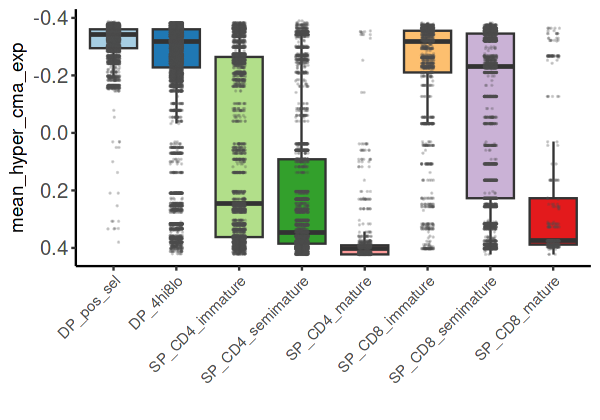

In [14]:
options(repr.plot.width=5, repr.plot.height=3.5)

ggplot(seurObj_SP3@meta.data, aes(x=anno_CITE_new, y=mean_hyper_cma_exp, fill=anno_CITE_new))+
geom_boxplot(outlier.shape = NA)+
geom_jitter_rast(alpha=0.2, size=0.1, width=0.1, color='grey30')+
theme_bw()+
scale_y_reverse()+
theme(axis.text.x = element_text(angle=45, hjust=1), axis.text.y = element_text(size = 12), panel.grid = element_blank(),
           panel.border = element_blank(), axis.line.x = element_line(size = 0.5, linetype = "solid", colour = "black"),
axis.line.y = element_line(size = 0.5, linetype = "solid", colour = "black"))+scale_fill_manual(values = pal10v2)+
NoLegend()+
labs(x='')

In [15]:
expr2.df <- as.matrix(seurObj_SP3@assays$ADTdsb@data) %>% t %>% data.frame %>% cbind(.,
                                                                       seurObj_SP3@meta.data,
                                                                       data.frame(t(as.matrix(seurObj_SP3@assays$RNA@data[rownames(seurObj_SP3@assays$RNA@data) %in% c('CXCR3', 'CXCR4','CCR4', 'CCR6', 'CCR7', 'CCR8', 'CCR9'),]))))

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 6924 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 6924 rows containing missing values (`geom_point()`).”
`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 11217 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 11217 rows containing missing values (`geom_point()`).”


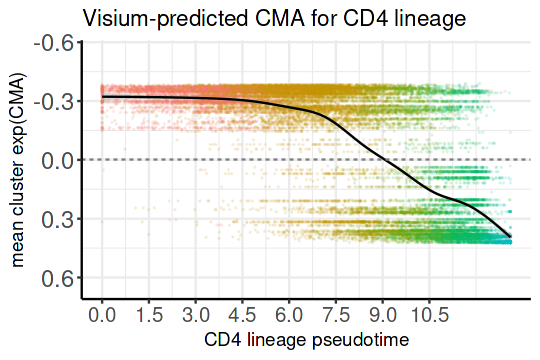

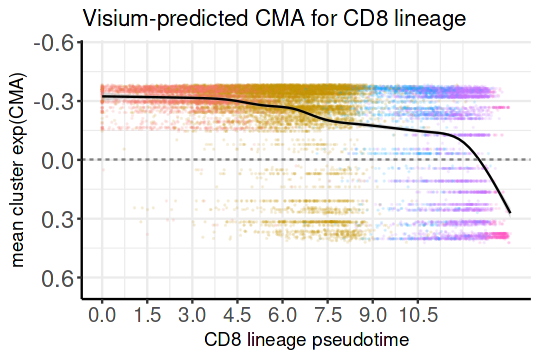

In [16]:
options(repr.plot.width=4.5, repr.plot.height=3)

cma_lineage4 <- ggplot(expr2.df, aes(y=mean_hyper_cma_exp, x=spt_CD4))+
geom_jitter_rast(aes(color=anno_CITE_new), size=0.1, alpha=0.1)+
geom_smooth(se=T, method = 'gam', color='black', size=0.5)+
theme_bw()+
geom_hline(yintercept = 0, linetype=2, color='grey50')+
scale_y_reverse()+
coord_cartesian(ylim = c(0.65,-0.55))+
theme(axis.text.x = element_text(size=12), axis.text.y = element_text(size = 14),
           panel.border = element_blank(), axis.line.x = element_line(size = 0.5, linetype = "solid", colour = "black"),
axis.line.y = element_line(size = 0.5, linetype = "solid", colour = "black"))+theme(legend.key = element_rect(fill = "white"))+
labs(title='Visium-predicted CMA for CD4 lineage', y='mean cluster exp(CMA)', x='CD4 lineage pseudotime')+
scale_x_continuous(breaks=seq(0,10.5,1.5))&NoLegend()

cma_lineage8 <- ggplot(expr2.df, aes(y=mean_hyper_cma_exp, x=spt_CD8))+
geom_jitter_rast(aes(color=anno_CITE_new), size=0.1, alpha=0.1)+
geom_smooth(se=T, method = 'gam', color='black', size=0.5)+
theme_bw()+
geom_hline(yintercept = 0, linetype=2, color='grey50')+
scale_y_reverse()+
coord_cartesian(ylim = c(0.65,-0.55))+
theme(axis.text.x = element_text(size=12), axis.text.y = element_text(size = 14),
           panel.border = element_blank(), axis.line.x = element_line(size = 0.5, linetype = "solid", colour = "black"),
axis.line.y = element_line(size = 0.5, linetype = "solid", colour = "black"))+theme(legend.key = element_rect(fill = "white"))+
labs(title='Visium-predicted CMA for CD8 lineage', y='mean cluster exp(CMA)', x='CD8 lineage pseudotime')+
scale_x_continuous(breaks=seq(0,10.5,1.5))&NoLegend()

cma_lineage4

cma_lineage8

In [17]:
cma_visium_summary <- expr2.df %>%
    group_by(anno_CITE_new) %>% summarise(
    visium_spt_CD4_median = median(spt_CD4, na.rm = T),                  
    visium_spt_CD4_q05 = quantile(spt_CD4, probs = 0.05, na.rm = T),
    visium_spt_CD4_q95 = quantile(spt_CD4, probs = 0.95, na.rm = T),
    visium_spt_CD8_median = median(spt_CD8, na.rm = T),                  
    visium_spt_CD8_q05 = quantile(spt_CD8, probs = 0.05, na.rm = T),
    visium_spt_CD8_q95 = quantile(spt_CD8, probs = 0.95, na.rm = T))

cma_visium_summary <- expr2.df %>%
    subset(!is.na(spt_CD8)) %>% 
    group_by(anno_CITE_new) %>% summarise(
    visium_cma_median_CD8 = median(mean_hyper_cma_exp, na.rm = T),                  
    visium_cma_q05_CD8 = quantile(mean_hyper_cma_exp, probs = 0.05, na.rm = T),
    visium_cma_q95_CD8 = quantile(mean_hyper_cma_exp, probs = 0.95, na.rm = T)) %>%
    left_join(cma_visium_summary, .)

cma_visium_summary <- expr2.df %>%
    subset(!is.na(spt_CD4)) %>% 
    group_by(anno_CITE_new) %>% summarise(
    visium_cma_median_CD4 = median(mean_hyper_cma_exp, na.rm = T),                  
    visium_cma_q05_CD4 = quantile(mean_hyper_cma_exp, probs = 0.05, na.rm = T),
    visium_cma_q95_CD4 = quantile(mean_hyper_cma_exp, probs = 0.95, na.rm = T)) %>%
    left_join(cma_visium_summary, .)

cma_visium_summary

Joining with `by = join_by(anno_CITE_new)`
Joining with `by = join_by(anno_CITE_new)`


anno_CITE_new,visium_spt_CD4_median,visium_spt_CD4_q05,visium_spt_CD4_q95,visium_spt_CD8_median,visium_spt_CD8_q05,visium_spt_CD8_q95,visium_cma_median_CD8,visium_cma_q05_CD8,visium_cma_q95_CD8,visium_cma_median_CD4,visium_cma_q05_CD4,visium_cma_q95_CD4
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DP_pos_sel,3.248862,0.3314702,5.434905,3.251955,0.3329675,5.474431,-0.3402970,-0.3753867,-0.1920781,-0.3402970,-0.3753867,-0.1920781
DP_4hi8lo,6.585745,3.5161141,8.906655,6.476359,3.4527135,8.406464,-0.3226203,-0.3785841,0.3162954,-0.3170349,-0.3755282,0.3323611
SP_CD4_immature,9.684392,7.7922967,11.152106,NA,NA,NA,NA,NA,NA,0.2448211,-0.3637736,0.4007134
SP_CD4_semimature,11.477230,10.0241553,12.376214,NA,NA,NA,NA,NA,NA,0.3450876,-0.3417755,0.4151675
SP_CD4_mature,12.773120,11.6759934,13.100860,NA,NA,NA,NA,NA,NA,0.4027977,0.1124551,0.4225475
SP_CD8_immature,NA,NA,NA,10.314397,7.6024023,11.836299,-0.3195044,-0.3739080,0.3338336,NA,NA,NA
SP_CD8_semimature,NA,NA,NA,11.834254,9.9547730,12.766009,-0.2313563,-0.3641022,0.3965281,NA,NA,NA
SP_CD8_mature,NA,NA,NA,13.164204,12.3777623,13.475224,0.3757495,-0.3230888,0.3965281,NA,NA,NA


Warning message:
“Removed 6924 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_errorbarh()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 11217 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_errorbarh()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`).”


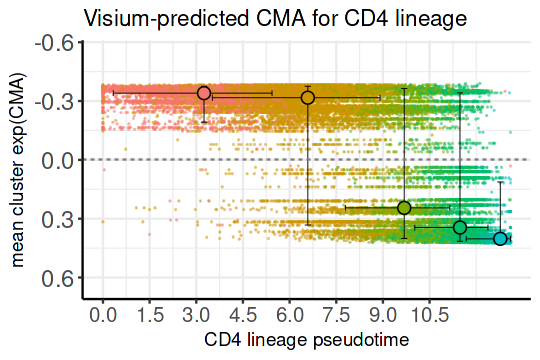

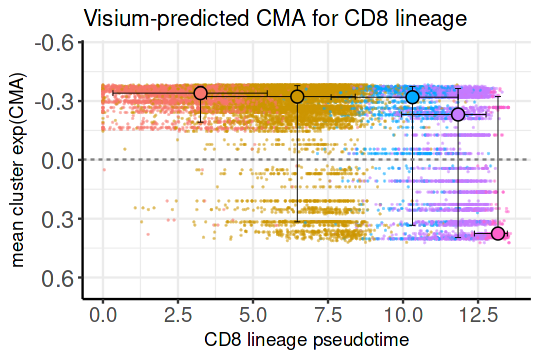

In [18]:
options(repr.plot.width=4.5, repr.plot.height=3)

cma_lineage4_visium <- ggplot()+
geom_jitter_rast(data=expr2.df, aes(y=mean_hyper_cma_exp, x=spt_CD4,color=anno_CITE_new), size=0.1, alpha=0.4)+
geom_errorbarh(data = cma_visium_summary,aes(xmin = visium_spt_CD4_q05,xmax = visium_spt_CD4_q95,y = visium_cma_median_CD4), height=0.03, size=0.2, color='black') + 
geom_errorbar(data = cma_visium_summary,aes(ymin = visium_cma_q05_CD4,ymax = visium_cma_q95_CD4,x = visium_spt_CD4_median), width=0.2, size=0.2, color='black')+
geom_point(data = cma_visium_summary,aes(x=visium_spt_CD4_median, y=visium_cma_median_CD4, fill = anno_CITE_new), size=3, shape=21, color='black') +
theme_bw()+
scale_y_reverse()+
geom_hline(yintercept = 0, linetype=2, color='grey50')+
coord_cartesian(ylim = c(0.65,-0.55))+
theme(axis.text.x = element_text(size=12), axis.text.y = element_text(size = 14),
           panel.border = element_blank(), axis.line.x = element_line(size = 0.5, linetype = "solid", colour = "black"),
axis.line.y = element_line(size = 0.5, linetype = "solid", colour = "black"))+theme(legend.key = element_rect(fill = "white"))+
labs(title='Visium-predicted CMA for CD4 lineage', y='mean cluster exp(CMA)', x='CD4 lineage pseudotime')+
scale_x_continuous(breaks=seq(0,10.5,1.5))&NoLegend()

cma_lineage8_visium <- ggplot()+
geom_jitter_rast(data=expr2.df, aes(y=mean_hyper_cma_exp, x=spt_CD8, color=anno_CITE_new), size=0.1, alpha=0.4)+
geom_errorbarh(data = cma_visium_summary,aes(xmin = visium_spt_CD8_q05,xmax = visium_spt_CD8_q95,y = visium_cma_median_CD8), height=0.03, size=0.2, color='black') + 
geom_errorbar(data = cma_visium_summary,aes(ymin = visium_cma_q05_CD8,ymax = visium_cma_q95_CD8,x = visium_spt_CD8_median), width=0.2, size=0.2, color='black')+
geom_point(data = cma_visium_summary,aes(x=visium_spt_CD8_median, y=visium_cma_median_CD8, fill = anno_CITE_new), size=3, shape=21, color='black') +
theme_bw()+
scale_y_reverse()+
geom_hline(yintercept = 0, linetype=2, color='grey50')+
coord_cartesian(ylim = c(0.65,-0.55))+
theme(axis.text.x = element_text(size=12), axis.text.y = element_text(size = 14),
           panel.border = element_blank(), axis.line.x = element_line(size = 0.5, linetype = "solid", colour = "black"),
axis.line.y = element_line(size = 0.5, linetype = "solid", colour = "black"))+theme(legend.key = element_rect(fill = "white"))+
labs(title='Visium-predicted CMA for CD8 lineage', y='mean cluster exp(CMA)', x='CD8 lineage pseudotime')+
scale_x_continuous(breaks=seq(0,12.5,2.5))&NoLegend()

cma_lineage4_visium
cma_lineage8_visium

Refined plot for figure:

Warning message:
“Removed 6924 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_errorbarh()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 11217 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_errorbarh()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`).”


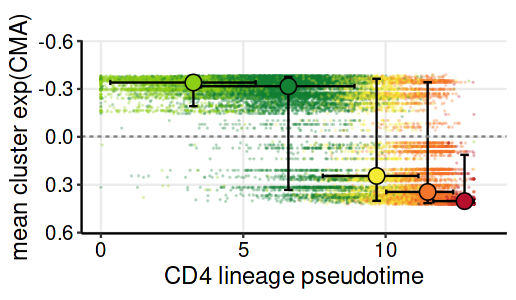

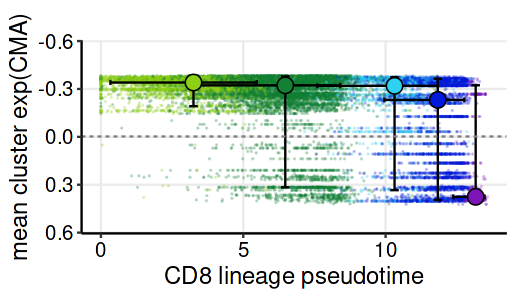

In [19]:
options(repr.plot.width=4.3, repr.plot.height=2.5)

cma_lineage4_visium <- ggplot()+
rasterise(geom_jitter(data=expr2.df, aes(y=mean_hyper_cma_exp, x=spt_CD4,color=anno_CITE_new), size=0.1, alpha=0.2), dpi=300)+
geom_errorbarh(data = cma_visium_summary,aes(xmin = visium_spt_CD4_q05,xmax = visium_spt_CD4_q95,y = visium_cma_median_CD4), height=0.03, size=0.5, color='black') + 
geom_errorbar(data = cma_visium_summary,aes(ymin = visium_cma_q05_CD4,ymax = visium_cma_q95_CD4,x = visium_spt_CD4_median), width=0.3, size=0.5, color='black')+
geom_point(data = cma_visium_summary,aes(x=visium_spt_CD4_median, y=visium_cma_median_CD4, fill = anno_CITE_new), size=4, shape=21, color='black') +
scale_color_manual(values = pal_SPs)+
scale_fill_manual(values = pal_SPs)+
theme_bw()+
scale_y_reverse()+
geom_hline(yintercept = 0, linetype=2, color='grey50')+
coord_cartesian(ylim = c(0.55,-0.55), xlim=c(0,max_CD8spt))+
theme(axis.text.x = element_text(size=12, color='black'), axis.text.y = element_text(size = 12, color='black'),
      axis.title = element_text(size=14), legend.text=element_text(size=12))+
theme(panel.border = element_blank(), axis.line = element_line(size = 0.5, linetype = "solid", colour = "black"))+
theme(legend.key = element_rect(fill = "white"))+
theme(panel.grid.minor.x = element_blank(), panel.grid.minor.y = element_blank())+labs(title='', y='mean cluster exp(CMA)', x='CD4 lineage pseudotime')+NoLegend()

cma_lineage8_visium <- ggplot()+
rasterise(geom_jitter_rast(data=expr2.df, aes(y=mean_hyper_cma_exp, x=spt_CD8, color=anno_CITE_new), size=0.1, alpha=0.2), dpi=300)+
geom_errorbarh(data = cma_visium_summary,aes(xmin = visium_spt_CD8_q05,xmax = visium_spt_CD8_q95,y = visium_cma_median_CD8), height=0.03, size=0.5, color='black') + 
geom_errorbar(data = cma_visium_summary,aes(ymin = visium_cma_q05_CD8,ymax = visium_cma_q95_CD8,x = visium_spt_CD8_median), width=0.3, size=0.5, color='black')+
geom_point(data = cma_visium_summary,aes(x=visium_spt_CD8_median, y=visium_cma_median_CD8, fill = anno_CITE_new), size=4, shape=21, color='black') +
scale_color_manual(values = pal_SPs)+
scale_fill_manual(values = pal_SPs)+
theme_bw()+
scale_y_reverse()+
geom_hline(yintercept = 0, linetype=2, color='grey50')+
coord_cartesian(ylim = c(0.55,-0.55), xlim=c(0,max_CD8spt))+
theme(axis.text.x = element_text(size=12, color='black'), axis.text.y = element_text(size = 12, color='black'),
      axis.title = element_text(size=14), legend.text=element_text(size=12))+
theme(panel.border = element_blank(), axis.line = element_line(size = 0.5, linetype = "solid", colour = "black"))+
theme(legend.key = element_rect(fill = "white"))+
theme(panel.grid.minor.x = element_blank(), panel.grid.minor.y = element_blank())+labs(title='', y='mean cluster exp(CMA)', x='CD8 lineage pseudotime')+NoLegend()


cma_lineage4_visium
cma_lineage8_visium

#### IBEX data

For IBEX data we used KNN=7 for annotation. CMA values, annotations, and pseudotime for IBEX cells was obtained.

In [26]:
cma_ibex_th7knn7 <- read.csv("")

Subset only for the annotations of interest.

In [27]:
cma_ibex_th7knn7 <- subset(cma_ibex_th7knn7, anno_CITE %in% c('DP_pos_sel','DP_4hi8lo', 'SP_CD4_immature', 'SP_CD4_semimature','SP_CD4_mature','SP_CD8_immature','SP_CD8_semimature', 'SP_CD8_mature'))

In [28]:
fraction_cuttoff <- 0.9 #use this to exclude cells with low annotation certainty

cma_ibex_summary_th7knn7 <- cma_ibex_th7knn7 %>%
    subset(anno_CITE_fraction >= fraction_cuttoff) %>% 
    group_by(anno_CITE) %>% summarise(
    ibex_spt_CD4_median = median(spt_CD4, na.rm = T),                  
    ibex_spt_CD4_q05 = quantile(spt_CD4, probs = 0.05, na.rm = T),
    ibex_spt_CD4_q95 = quantile(spt_CD4, probs = 0.95, na.rm = T),
    ibex_spt_CD8_median = median(spt_CD8, na.rm = T),                  
    ibex_spt_CD8_q05 = quantile(spt_CD8, probs = 0.05, na.rm = T),
    ibex_spt_CD8_q95 = quantile(spt_CD8, probs = 0.95, na.rm = T))

#need to calculate CMA means for lineages separately because for the hilo cells not all will be included in the pseudotime of both lineages

cma_ibex_summary_th7knn7 <- cma_ibex_th7knn7 %>%
    subset(anno_CITE_fraction >= fraction_cuttoff & !is.na(spt_CD4)) %>% 
    group_by(anno_CITE) %>% summarise(
    ibex_cma_median_CD4 = median(cma_v2_exp2, na.rm = T),                  
    ibex_cma_q05_CD4 = quantile(cma_v2_exp2, probs = 0.05, na.rm = T),
    ibex_cma_q95_CD4 = quantile(cma_v2_exp2, probs = 0.95, na.rm = T)) %>%
    left_join(cma_ibex_summary_th7knn7, .)

cma_ibex_summary_th7knn7 <- cma_ibex_th7knn7 %>%
    subset(anno_CITE_fraction >= fraction_cuttoff & !is.na(spt_CD8)) %>% 
    group_by(anno_CITE) %>% summarise(
    ibex_cma_median_CD8 = median(cma_v2_exp2, na.rm = T),                  
    ibex_cma_q05_CD8 = quantile(cma_v2_exp2, probs = 0.05, na.rm = T),
    ibex_cma_q95_CD8 = quantile(cma_v2_exp2, probs = 0.95, na.rm = T)) %>%
    left_join(cma_ibex_summary_th7knn7, .)


Joining with `by = join_by(anno_CITE)`
Joining with `by = join_by(anno_CITE)`


Warning message:
“Removed 203474 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 3 rows containing missing values (`geom_errorbarh()`).”
Warning message:
“Removed 3 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 232346 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 3 rows containing missing values (`geom_errorbarh()`).”
Warning message:
“Removed 3 rows containing missing values (`geom_point()`).”


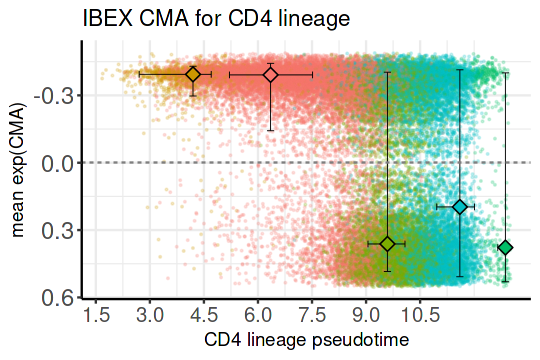

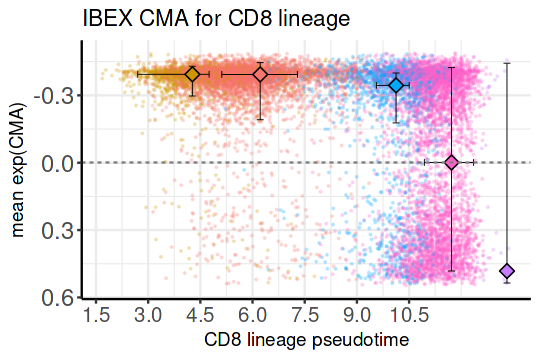

In [29]:
options(repr.plot.width=4.5, repr.plot.height=3)

cma_lineage4_ibex_th7knn7 <- ggplot() + 
    geom_point(data=cma_ibex_th7knn7, aes(x=spt_CD4, y=cma_v2_exp2, color=anno_CITE), size=0.1, alpha=0.2) + 
    geom_errorbarh(data = cma_ibex_summary_th7knn7,aes(xmin = ibex_spt_CD4_q05,xmax = ibex_spt_CD4_q95,y = ibex_cma_median_CD4,colour = anno_CITE), color='black', height=0.03, size=0.2) + 
    geom_errorbar(data = cma_ibex_summary_th7knn7,aes(ymin = ibex_cma_q05_CD4,ymax = ibex_cma_q95_CD4,x = ibex_spt_CD4_median,colour = anno_CITE), color='black', width=0.2, size=0.2)+
    geom_point(data = cma_ibex_summary_th7knn7,aes(x=ibex_spt_CD4_median, y=ibex_cma_median_CD4, fill = anno_CITE), size=3, shape=23, color='black') +
    scale_y_reverse()+
 #   coord_cartesian(ylim = c(0.65,-0.55), xlim = c(0,11.2))+
    theme_bw()+
    theme(axis.text.x = element_text(size=12), axis.text.y = element_text(size = 14),
           panel.border = element_blank(), axis.line.x = element_line(size = 0.5, linetype = "solid", colour = "black"),
            axis.line.y = element_line(size = 0.5, linetype = "solid", colour = "black"))+theme(legend.key = element_rect(fill = "white"))+
    theme(legend.key = element_rect(fill = "white"))+
    labs(title='IBEX CMA for CD4 lineage', y='mean exp(CMA)', x='CD4 lineage pseudotime')+
    geom_hline(yintercept = 0, linetype=2, color='grey50')+
    scale_x_continuous(breaks=seq(0,10.5,1.5))&NoLegend()

cma_lineage8_ibex_th7knn7 <- ggplot() + 
    geom_point(data=cma_ibex_th7knn7, aes(x=spt_CD8, y=cma_v2_exp2, color=anno_CITE), size=0.1, alpha=0.2) + 
    geom_errorbarh(data = cma_ibex_summary_th7knn7,aes(xmin = ibex_spt_CD8_q05,xmax = ibex_spt_CD8_q95,y = ibex_cma_median_CD8,colour = anno_CITE), color='black', height=0.03, size=0.2) + 
    geom_errorbar(data = cma_ibex_summary_th7knn7,aes(ymin = ibex_cma_q05_CD8,ymax = ibex_cma_q95_CD8,x = ibex_spt_CD8_median,colour = anno_CITE),color='black', width=0.2, size=0.2)+
    geom_point(data = cma_ibex_summary_th7knn7,aes(x=ibex_spt_CD8_median, y=ibex_cma_median_CD8, fill = anno_CITE), size=3, shape=23, color='black') +
    scale_y_reverse()+
 #   coord_cartesian(ylim = c(0.65,-0.55), xlim = c(0,11.2))+
    theme_bw()+
    theme(axis.text.x = element_text(size=12), axis.text.y = element_text(size = 14),
           panel.border = element_blank(), axis.line.x = element_line(size = 0.5, linetype = "solid", colour = "black"),
            axis.line.y = element_line(size = 0.5, linetype = "solid", colour = "black"))+theme(legend.key = element_rect(fill = "white"))+
    theme(legend.key = element_rect(fill = "white"))+
    labs(title='IBEX CMA for CD8 lineage', y='mean exp(CMA)', x='CD8 lineage pseudotime')+
    geom_hline(yintercept = 0, linetype=2, color='grey50')+
    scale_x_continuous(breaks=seq(0,10.5,1.5))&NoLegend()

cma_lineage4_ibex_th7knn7
cma_lineage8_ibex_th7knn7

In [20]:
celltypes <- levels(seurObj$anno_CITE_new)
names(celltypes) <- seq_along(celltypes)

In [21]:
cma_ibex_th7knn7$anno_CITE <- factor(cma_ibex_th7knn7$anno_CITE, levels= celltypes[10:17])
cma_ibex_summary_th7knn7$anno_CITE <- factor(cma_ibex_summary_th7knn7$anno_CITE, levels= celltypes[10:17])
spatial_summary_th7knn7$anno_CITE <- factor(spatial_summary_th7knn7$anno_CITE, levels= celltypes[10:17])

Warning message:
“Removed 203474 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_errorbarh()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 232346 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_errorbarh()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`).”


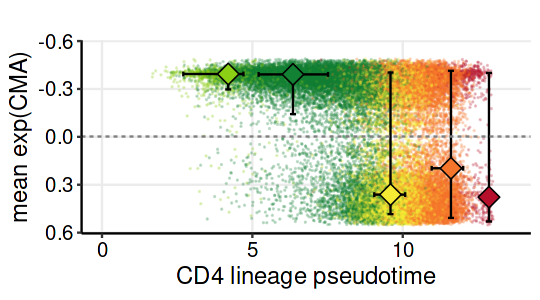

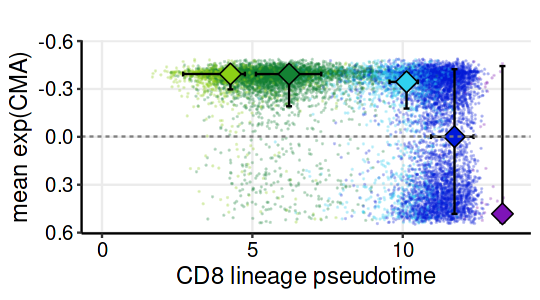

In [22]:
options(repr.plot.width=4.5, repr.plot.height=2.5)

cma_lineage4_ibex_th7knn7 <- ggplot() + 
    rasterise(geom_point(data=cma_ibex_th7knn7, aes(x=spt_CD4, y=cma_v2_exp2, color=anno_CITE), size=0.1, alpha=0.2), dpi=300)+ 
    geom_errorbarh(data = cma_ibex_summary_th7knn7,aes(xmin = ibex_spt_CD4_q05,xmax = ibex_spt_CD4_q95,y = ibex_cma_median_CD4,colour = anno_CITE), color='black', height=0.03, size=0.5) + 
    geom_errorbar(data = cma_ibex_summary_th7knn7,aes(ymin = ibex_cma_q05_CD4,ymax = ibex_cma_q95_CD4,x = ibex_spt_CD4_median,colour = anno_CITE), color='black', width=0.2, size=0.5)+
    geom_point(data = cma_ibex_summary_th7knn7,aes(x=ibex_spt_CD4_median, y=ibex_cma_median_CD4, fill = anno_CITE), size=4.5, shape=23, color='black') +
    scale_y_reverse()+
    scale_color_manual(values = pal_SPs)+
    scale_fill_manual(values = pal_SPs)+
    coord_cartesian(ylim = c(0.55,-0.55), xlim=c(0,max_CD8spt))+
    theme_bw()+
    theme(axis.text.x = element_text(size=12, color='black'), axis.text.y = element_text(size = 12, color='black'),
      axis.title = element_text(size=14), legend.text=element_text(size=12))+
    theme(panel.border = element_blank(), axis.line = element_line(size = 0.5, linetype = "solid", colour = "black"))+
    theme(legend.key = element_rect(fill = "white"))+
    theme(panel.grid.minor.x = element_blank(), panel.grid.minor.y = element_blank())+
    labs(title='', y='mean exp(CMA)', x='CD4 lineage pseudotime')+NoLegend()+
    geom_hline(yintercept = 0, linetype=2, color='grey50')&NoLegend()

cma_lineage8_ibex_th7knn7 <- ggplot() + 
    rasterise(geom_point(data=cma_ibex_th7knn7, aes(x=spt_CD8, y=cma_v2_exp2, color=anno_CITE), size=0.1, alpha=0.2), dpi=300)+ 
    geom_errorbarh(data = cma_ibex_summary_th7knn7,aes(xmin = ibex_spt_CD8_q05,xmax = ibex_spt_CD8_q95,y = ibex_cma_median_CD8,colour = anno_CITE), color='black', height=0.03, size=0.5) + 
    geom_errorbar(data = cma_ibex_summary_th7knn7,aes(ymin = ibex_cma_q05_CD8,ymax = ibex_cma_q95_CD8,x = ibex_spt_CD8_median,colour = anno_CITE),color='black', width=0.2, size=0.5)+
    geom_point(data = cma_ibex_summary_th7knn7,aes(x=ibex_spt_CD8_median, y=ibex_cma_median_CD8, fill = anno_CITE), size=4.5, shape=23, color='black') +
    scale_y_reverse()+
    scale_color_manual(values = pal_SPs)+
    scale_fill_manual(values = pal_SPs)+
    coord_cartesian(ylim = c(0.55,-0.55), xlim=c(0,max_CD8spt))+
    theme_bw()+
    theme(axis.text.x = element_text(size=12, color='black'), axis.text.y = element_text(size = 12, color='black'),
      axis.title = element_text(size=14), legend.text=element_text(size=12))+
    theme(panel.border = element_blank(), axis.line = element_line(size = 0.5, linetype = "solid", colour = "black"))+
    theme(legend.key = element_rect(fill = "white"))+
    theme(panel.grid.minor.x = element_blank(), panel.grid.minor.y = element_blank())+
    labs(title='', y='mean exp(CMA)', x='CD8 lineage pseudotime')+NoLegend()+
    geom_hline(yintercept = 0, linetype=2, color='grey50')&NoLegend()

cma_lineage4_ibex_th7knn7
cma_lineage8_ibex_th7knn7

#### Visium vs. IBEX comparison

In [30]:
spatial_summary_th7knn7 <- left_join(cma_ibex_summary_th7knn7, cma_visium_summary, join_by(anno_CITE==anno_CITE_new))

Warning message:
“Removed 3 rows containing missing values (`geom_errorbarh()`).”
Warning message:
“Removed 3 rows containing missing values (`geom_errorbarh()`).”
Warning message:
“Removed 3 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 3 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 3 rows containing missing values (`geom_errorbarh()`).”
Warning message:
“Removed 3 rows containing missing values (`geom_errorbarh()`).”
Warning message:
“Removed 3 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 3 rows containing missing values (`geom_point()`).”


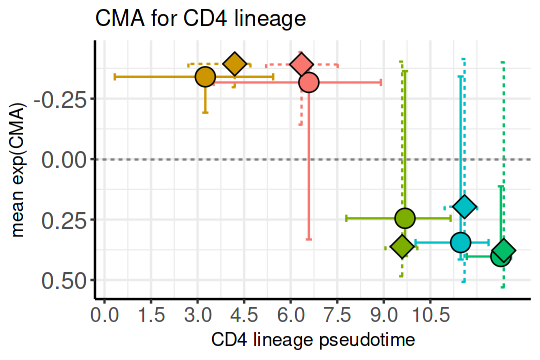

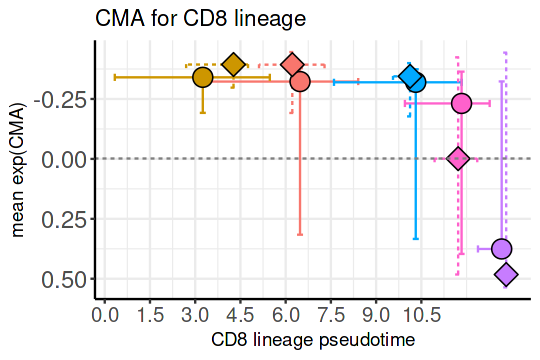

In [31]:
options(repr.plot.width=4.5, repr.plot.height=3)

comp_pseu_CD4_th7knn7 <- ggplot() + 
   geom_errorbarh(data = spatial_summary_th7knn7,aes(xmin = visium_spt_CD4_q05,xmax = visium_spt_CD4_q95,y = visium_cma_median_CD4,colour = anno_CITE), height=0.03) + 
   geom_errorbar(data = spatial_summary_th7knn7,aes(ymin = visium_cma_q05_CD4,ymax = visium_cma_q95_CD4,x = visium_spt_CD4_median,colour = anno_CITE), width=0.2)+
   geom_errorbarh(data = spatial_summary_th7knn7,aes(xmin = ibex_spt_CD4_q05,xmax = ibex_spt_CD4_q95,y = ibex_cma_median_CD4,colour = anno_CITE), height=0.03, linetype=2) + 
    geom_errorbar(data = spatial_summary_th7knn7,aes(ymin = ibex_cma_q05_CD4,ymax = ibex_cma_q95_CD4,x = ibex_spt_CD4_median,colour = anno_CITE), width=0.2, linetype=2)+
    geom_point(data = spatial_summary_th7knn7,aes(x=visium_spt_CD4_median, y=visium_cma_median_CD4, fill = anno_CITE), size=5, shape=21, color='black') +
   geom_point(data = spatial_summary_th7knn7,aes(x=ibex_spt_CD4_median, y=ibex_cma_median_CD4, fill = anno_CITE), size=5, shape=23, color='black') +
    scale_y_reverse()+
 #   coord_cartesian(ylim = c(0.65,-0.55))+
    theme_bw()+
    theme(axis.text.x = element_text(size=12), axis.text.y = element_text(size = 14),
           panel.border = element_blank(), axis.line.x = element_line(size = 0.5, linetype = "solid", colour = "black"),
            axis.line.y = element_line(size = 0.5, linetype = "solid", colour = "black"))+theme(legend.key = element_rect(fill = "white"))+
    theme(legend.key = element_rect(fill = "white"))+
    labs(title='CMA for CD4 lineage', y='mean exp(CMA)', x='CD4 lineage pseudotime')+
    geom_hline(yintercept = 0, linetype=2, color='grey50')+
    scale_x_continuous(breaks=seq(0,10.5,1.5))&NoLegend()

comp_pseu_CD8_th7knn7 <- ggplot() + 
   geom_errorbarh(data = spatial_summary_th7knn7,aes(xmin = visium_spt_CD8_q05,xmax = visium_spt_CD8_q95,y = visium_cma_median_CD8,colour = anno_CITE), height=0.03) + 
   geom_errorbar(data = spatial_summary_th7knn7,aes(ymin = visium_cma_q05_CD8,ymax = visium_cma_q95_CD8,x = visium_spt_CD8_median,colour = anno_CITE), width=0.2)+
   geom_errorbarh(data = spatial_summary_th7knn7,aes(xmin = ibex_spt_CD8_q05,xmax = ibex_spt_CD8_q95,y = ibex_cma_median_CD8,colour = anno_CITE), height=0.03, linetype=2) + 
    geom_errorbar(data = spatial_summary_th7knn7,aes(ymin = ibex_cma_q05_CD8,ymax = ibex_cma_q95_CD8,x = ibex_spt_CD8_median,colour = anno_CITE), width=0.2, linetype=2)+
    geom_point(data = spatial_summary_th7knn7,aes(x=visium_spt_CD8_median, y=visium_cma_median_CD8, fill = anno_CITE), size=5, shape=21, color='black') +
   geom_point(data = spatial_summary_th7knn7,aes(x=ibex_spt_CD8_median, y=ibex_cma_median_CD8, fill = anno_CITE), size=5, shape=23, color='black') +
    scale_y_reverse()+
 #   coord_cartesian(ylim = c(0.65,-0.55))+
    theme_bw()+
    theme(axis.text.x = element_text(size=12), axis.text.y = element_text(size = 14),
           panel.border = element_blank(), axis.line.x = element_line(size = 0.5, linetype = "solid", colour = "black"),
            axis.line.y = element_line(size = 0.5, linetype = "solid", colour = "black"))+theme(legend.key = element_rect(fill = "white"))+
    theme(legend.key = element_rect(fill = "white"))+
    labs(title='CMA for CD8 lineage', y='mean exp(CMA)', x='CD8 lineage pseudotime')+
    geom_hline(yintercept = 0, linetype=2, color='grey50')+
    scale_x_continuous(breaks=seq(0,10.5,1.5))&NoLegend()

comp_pseu_CD4_th7knn7
comp_pseu_CD8_th7knn7

Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_errorbarh()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_errorbarh()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_errorbarh()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_errorbarh()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`).”


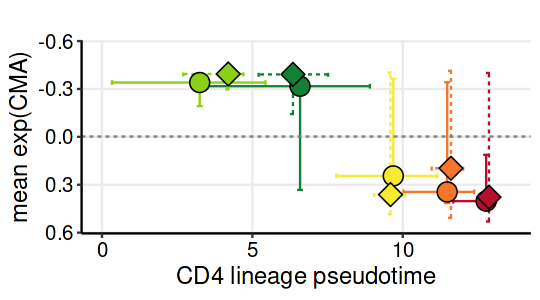

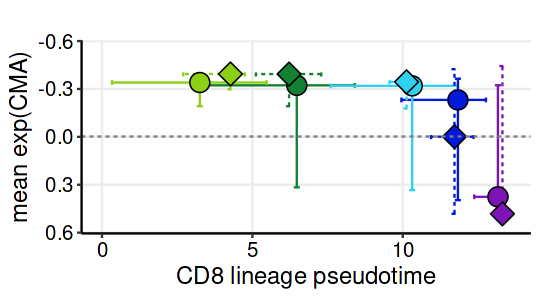

In [23]:
options(repr.plot.width=4.5, repr.plot.height=2.5)

comp_pseu_CD4_th7knn7 <- ggplot() + 
   geom_errorbarh(data = spatial_summary_th7knn7,aes(xmin = visium_spt_CD4_q05,xmax = visium_spt_CD4_q95,y = visium_cma_median_CD4,colour = anno_CITE), height=0.03) + 
   geom_errorbar(data = spatial_summary_th7knn7,aes(ymin = visium_cma_q05_CD4,ymax = visium_cma_q95_CD4,x = visium_spt_CD4_median,colour = anno_CITE), width=0.2)+
   geom_errorbarh(data = spatial_summary_th7knn7,aes(xmin = ibex_spt_CD4_q05,xmax = ibex_spt_CD4_q95,y = ibex_cma_median_CD4,colour = anno_CITE), height=0.03, linetype=2) + 
    geom_errorbar(data = spatial_summary_th7knn7,aes(ymin = ibex_cma_q05_CD4,ymax = ibex_cma_q95_CD4,x = ibex_spt_CD4_median,colour = anno_CITE), width=0.2, linetype=2)+
    geom_point(data = spatial_summary_th7knn7,aes(x=visium_spt_CD4_median, y=visium_cma_median_CD4, fill = anno_CITE), size=5, shape=21, color='black') +
   geom_point(data = spatial_summary_th7knn7,aes(x=ibex_spt_CD4_median, y=ibex_cma_median_CD4, fill = anno_CITE), size=5, shape=23, color='black') +
    scale_y_reverse()+
    scale_color_manual(values = pal_SPs)+
    scale_fill_manual(values = pal_SPs)+
    coord_cartesian(ylim = c(0.55,-0.55), xlim=c(0,max_CD8spt))+
    theme_bw()+
    theme(axis.text.x = element_text(size=12, color='black'), axis.text.y = element_text(size = 12, color='black'),
      axis.title = element_text(size=14), legend.text=element_text(size=12))+
    theme(panel.border = element_blank(), axis.line = element_line(size = 0.5, linetype = "solid", colour = "black"))+
    theme(legend.key = element_rect(fill = "white"))+
    theme(panel.grid.minor.x = element_blank(), panel.grid.minor.y = element_blank())+
    labs(title='', y='mean exp(CMA)', x='CD4 lineage pseudotime')+NoLegend()+
    geom_hline(yintercept = 0, linetype=2, color='grey50')&NoLegend()

comp_pseu_CD8_th7knn7 <- ggplot() + 
   geom_errorbarh(data = spatial_summary_th7knn7,aes(xmin = visium_spt_CD8_q05,xmax = visium_spt_CD8_q95,y = visium_cma_median_CD8,colour = anno_CITE), height=0.03) + 
   geom_errorbar(data = spatial_summary_th7knn7,aes(ymin = visium_cma_q05_CD8,ymax = visium_cma_q95_CD8,x = visium_spt_CD8_median,colour = anno_CITE), width=0.2)+
   geom_errorbarh(data = spatial_summary_th7knn7,aes(xmin = ibex_spt_CD8_q05,xmax = ibex_spt_CD8_q95,y = ibex_cma_median_CD8,colour = anno_CITE), height=0.03, linetype=2) + 
    geom_errorbar(data = spatial_summary_th7knn7,aes(ymin = ibex_cma_q05_CD8,ymax = ibex_cma_q95_CD8,x = ibex_spt_CD8_median,colour = anno_CITE), width=0.2, linetype=2)+
    geom_point(data = spatial_summary_th7knn7,aes(x=visium_spt_CD8_median, y=visium_cma_median_CD8, fill = anno_CITE), size=5, shape=21, color='black') +
   geom_point(data = spatial_summary_th7knn7,aes(x=ibex_spt_CD8_median, y=ibex_cma_median_CD8, fill = anno_CITE), size=5, shape=23, color='black') +
    scale_y_reverse()+
    scale_color_manual(values = pal_SPs)+
    scale_fill_manual(values = pal_SPs)+
    coord_cartesian(ylim = c(0.55,-0.55), xlim=c(0,max_CD8spt))+
    theme_bw()+
    theme(axis.text.x = element_text(size=12, color='black'), axis.text.y = element_text(size = 12, color='black'),
      axis.title = element_text(size=14), legend.text=element_text(size=12))+
    theme(panel.border = element_blank(), axis.line = element_line(size = 0.5, linetype = "solid", colour = "black"))+
    theme(legend.key = element_rect(fill = "white"))+
    theme(panel.grid.minor.x = element_blank(), panel.grid.minor.y = element_blank())+
    labs(title='', y='mean exp(CMA)', x='CD8 lineage pseudotime')+NoLegend()+
    geom_hline(yintercept = 0, linetype=2, color='grey50')&NoLegend()

comp_pseu_CD4_th7knn7
comp_pseu_CD8_th7knn7